This tutorial will give an example of how to use Riroriro to generate a synthetic gravitational wave signal for a binary black hole merger.

In [1]:
import numpy as np

import riroriro.inspiralfuns as ins

We pick a system with mass log(Mc/Msun) = 1.4 and mass ratio q = 0.8, chosen for being comparable to the system that generated GW150914, the first detected gravitational wave signal. You can adjust the values below; for best results,  choose log(Mc/Msun) between 0.0 and 2.0 and q between 0.1 and 1.0, the ranges over which these parameters have been tested.

For the other parameters we choose defaults; note that the distance here is set to 100.0 Mpc here as the module for calculating the SNR of a gravitational waveform (snrcalculatorfuns) assumes the waveform was generated with this default distance, and the distance at which you want to calculate the SNR of the merger can then be set at that point. However, as long as you keep that in mind the distance could be adjusted here e.g. for graphing purposes.

If the merger you are generating the gravitational wave signal for is a binary black hole merger, set merger_type to be 'BH'. For binary neutron star and black hole–neutron star mergers, use 'NS'. For a 'NS' waveform, you should only simulate the inspiral portion (inspiralfuns) and not the merger/ringdown (as the mathematical equations used for the merger/ringdown are only valid for black holes and for neutron star mergers this phase would be beyond the detectable range of LIGO anyway), while for a 'BH' you should simulate both parts.

# Inspiral portion (inspiralfuns)

We start by computing the waveform for the inspiral portion of the merger, and then separately compute the merger/ringdown portion and match them together.

We obtain the total mass M and symmetric mass ratio eta, and then calculate two parameters used by a subsequent integration.

In [2]:
#GW150914-like
logMc=1.4
q=0.8

#defaults
flow=10.0           #(Hz)
merger_type='BH'
D=100.0             #(Mpc)

M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
start_x = ins.startx(M,flow)
end_x = ins.endx(eta,merger_type)

We integrate a quantity called the post-Newtonian parameter, which does not directly translate to an observable property of the system but is used in the subsequent calculations.

In [3]:
x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)

We convert the timesteps from the integration of the post-Newtonian parameter, initially given in geometric units, into the real units of seconds.

In [4]:
realtimes = ins.inspiral_time_conversion(xtimes,M)

We calculate the phase, angular frequency and linear frequency of the inspiralling binary at each timestep.

In [5]:
i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)

Next, we calculate the radius and its time-derivative.

In [6]:
r, rdot = ins.radius_calculation(x,M,eta)

In two steps, we calculate the values over time of the two polarisations (orthogonal/plus and diagonal/cross) of the gravitational waveform.

In [7]:
A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)

In [8]:
Aorth, Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)

Using the strain polarisations, we compute the overall strain amplitude of the signal over the duration of the inspiral.

In [9]:
i_amp = ins.inspiral_strain_amplitude(Aorth,Adiag)

Below, we reduce the size of the lists we will use again in the subsequent calculations, for the purposes of reducing the file size of the ultimate output file containing the data of the gravitational waveform. The reduction factor of 100 chosen here has a negligible effect on the numerical properties of the signal. This step is not necessary for the subsequent calculations and rather done for convenience, so you can skip it if you want.

In [13]:
i_time = ins.list_size_reducer(100,realtimes)
i_omega = ins.list_size_reducer(100,omega)
i_phase = ins.list_size_reducer(100,i_phase)
i_amp = ins.list_size_reducer(100,i_amp)

# Starting the merger/ringdown portion (mergerfirstfuns)

Now, we begin the calculations for the merger/ringdown portion of the waveform.

In [14]:
import riroriro.mergerfirstfuns as me1

These first few calculations are just to compute some constant coefficients, depending only on the symmetric mass ratio, that are used by the subsequent calculations.

In [15]:
sfin, wqnm = me1.quasi_normal_modes(eta)
alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)

Next, we calculate the frequencies for the merger/ringdown portion.

In [16]:
fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)

In [17]:
fhatdot = me1.fhat_differentiation(fhat)

As with the inspiral, we convert the timesteps from geometric units to seconds.

In [18]:
m_time = me1.merger_time_conversion(M)

# Matching the inspiral and merger/ringdown (matchingfuns)

Before we calculate more parameters for the merger/ringdown portion, we start to match together the inspiral and merger/ringdown portions into a single waveform for the whole process.

In [19]:
import riroriro.matchingfuns as mat

We calculate the timestep indices at which the switch from inspiral to merger/ringdown should occur to give the smoothest transition in frequency and frequency gradient, and calculate the offset that needs to be applied to the real-unit time data for the merger/ringdown portion so that the two portions are aligned in time at the transition.

In [20]:
min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)

In [21]:
final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)

Using the parameters calculated above, we create combined lists for the time and angular frequency values for the whole binary merger, including both portions and the proper transition between them.

In [22]:
i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)

We convert the angular frequency of the merging binary to a linear frequency, which is what would be observed by gravitational wave detectors.

In [23]:
i_m_freq = mat.frequency_SI_units(i_m_omega,M)

# Rest of merger/ringdown functions (mergersecondfuns)

In [24]:
import riroriro.mergersecondfuns as me2

We now calculate the values of phase for the merger/ringdown portion and then combine the inspiral and merger/ringdown phase lists, making sure that the phase values are smooth across the transition (we compute this after doing the matching so that we know when the transition is).

In [25]:
m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)

In [26]:
i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)

We calculate the strain amplitude for the merger/ringdown portion and then combine the amplitude lists for the two portions of the waveform.

In [27]:
m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)

In [28]:
i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)

Below are graphs showing the values of the strain (envelope) amplitude and frequency over time for the whole waveform.

Text(0, 0.5, 'Frequency (Hz)')

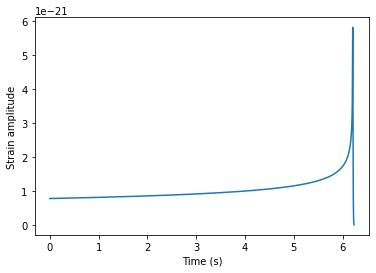

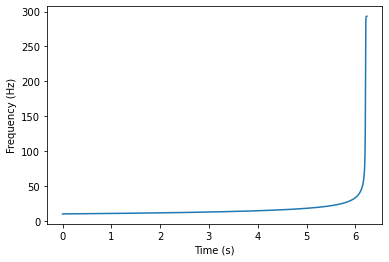

In [29]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(i_m_time,i_m_amp)
plt.xlabel('Time (s)')
plt.ylabel('Strain amplitude')

plt.figure(2)
plt.plot(i_m_time,i_m_freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')